In [1]:
import numpy as np
import pandas as pd
import glob
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import get_train_and_test_data

from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error

In [2]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

2022-06-29 23:18:27.155619: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-29 23:18:27.155634: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-29 23:18:27.155669: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
)

In [3]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [4]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [5]:
target = 'Tavg'
scale = True

In [6]:
# Get the train and test index by randomly splitting up data (80-20 train-test split)
train_index, test_index = get_train_and_test_index(scenario_index)

In [7]:
# Get train and test data
X_train, y_train, X_test, y_test, scaler_x, scaler_y = get_train_and_test_data(scenario_index, train_index, test_index, target, scale)

In [8]:
# Get the model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(3,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


2022-06-29 23:19:07.684363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Fit the model to training data
model.fit(x=X_train, 
          y=y_train,
          batch_size=300,
          epochs=10,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, earlystopping_callback])

2022-06-29 23:19:11.603679: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
 255/6738 [>.............................] - ETA: 5s - loss: 0.2000

2022-06-29 23:19:11.946529: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-29 23:19:11.946547: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-29 23:19:11.948722: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-29 23:19:11.950143: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-29 23:19:11.953239: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220629-231827/train/plugins/profile/2022_06_29_23_19_11
2022-06-29 23:19:11.954963: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220629-231827/train/plugins/profile/2022_06_29_23_19_11/kmenear-33762s.trace.json.gz
2022-06-29 23:19:11.957744: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220629-231827/train/plugi

6738/6738 [==============================] - 6s 810us/step - loss: 0.0147 - val_loss: 0.0047
Epoch 2/10
6738/6738 [==============================] - 5s 730us/step - loss: 2.3938e-05 - val_loss: 0.0040
Epoch 3/10
6738/6738 [==============================] - 5s 745us/step - loss: 1.9396e-05 - val_loss: 0.0035
Epoch 4/10
6738/6738 [==============================] - 5s 736us/step - loss: 1.8576e-05 - val_loss: 0.0032
Epoch 5/10
6738/6738 [==============================] - 5s 707us/step - loss: 1.7505e-05 - val_loss: 0.0032


In [10]:
# Get predictions for test data
y_hat = model.predict(X_test)

In [11]:
y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

In [12]:
# Evaluate results
rmse = mean_squared_error(y_test, y_hat, squared=False)
print(rmse)

2.9610007362330255


In [13]:
r2 = r2_score(y_test, y_hat)
print(r2)

0.9950677386841495


In [14]:
test_df = load_data(scenario_index, test_index)
test_df[target+"_hat"] = y_hat

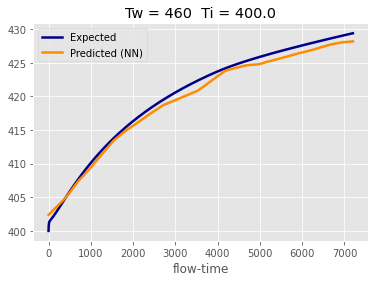

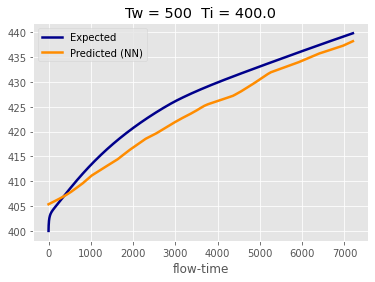

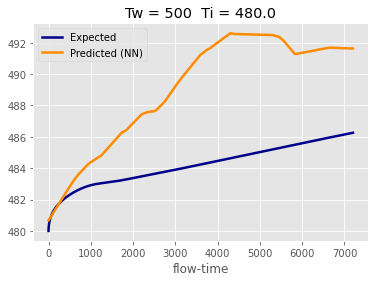

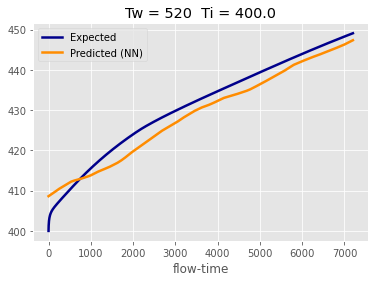

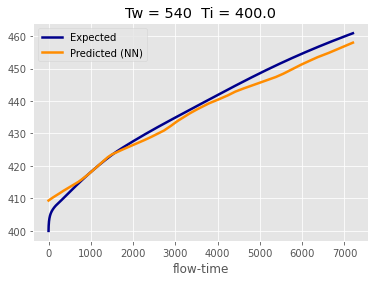

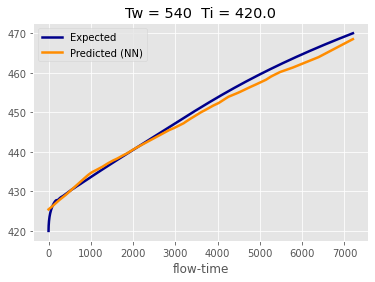

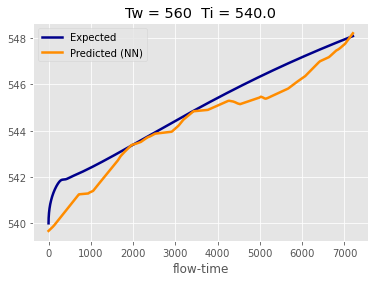

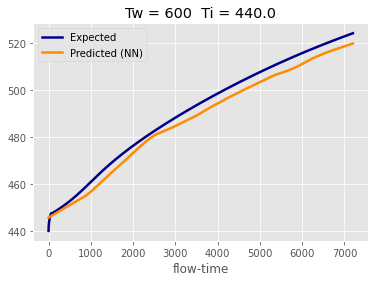

In [15]:
plot_test_results(test_df, 'NN', target)